# Job Queue Demo: Qubit Spectroscopy + Amplitude Rabi

This notebook demonstrates the job queue using **CharacterizationRunner**.

**Workflow:**
1. **Qubit Spectroscopy** - Find the qubit frequency
2. **Amplitude Rabi** - Calibrate pulse amplitude using the found frequency

The only difference from local execution is adding `job_client` and `user` to the runner.

## Prerequisites

Start the server and worker in separate terminals (only once for the fridge!):

```bash
# Terminal 1: Start the FastAPI server
cd D:\python\multimode_expts
pixi run python -u -m uvicorn job_server.server:app --host 0.0.0.0 --port 8000
# Note that if you are having problems here, it's possible that you accidentally started another server with a different host but some port. If so, double check this should only have 1 entry (in bash shell)
netstat -ano | grep :8000 | grep LISTENING

# Terminal 2: Start the worker
# If you try to start a second worker and there is already one existing, an error will be thrown.
# It's important to run this in unbufferred mode (-u) otherwise some weird things can happen with job submission
pixi run python -u -m job_server.worker
```

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Add multimode_expts to path for imports
# Adjust this path if running from a different location
# sys.path.insert(0, "/Users/conniemiao/GDriveStanford/SchusterLab/local_multimode/multimode_expts")

from copy import deepcopy

import experiments as meas
from slab import AttrDict
from experiments import MultimodeStation, CharacterizationRunner, SweepRunner

from job_server import JobClient
from job_server.database import get_database
from job_server.config_versioning import ConfigVersionManager

# Initialize database and config manager
db = get_database()
config_dir = 'D:/python/multimode_expts/configs'
config_manager = ConfigVersionManager(config_dir)

# Initialize job client (handle submitting and waiting for jobs)
client = JobClient()

Importing all classes from  D:\python\multimode_expts\experiments\dual_rail
Importing all classes from  D:\python\multimode_expts\experiments\qsim
Importing all classes from  D:\python\multimode_expts\experiments\qubit_cavity
Importing all classes from  D:\python\multimode_expts\experiments\single_qubit
Skipped top-level files ['characterization_runner.py', 'dataset.py', 'MM_base.py', 'MM_dual_rail_base.py', 'MM_rb_base.py', 'mock_hardware.py', 'sequential_experiment.py', 'sequential_experiment_classes.py', 'station.py', 'sweep_runner.py']


In [ ]:
# Initialize station to retrieve soc and configs
station = MultimodeStation(
    user='connie',
    experiment_name='job_queue_demo',
    # # these can also be optional (if a main config has already been set) or a version ID
    # hardware_config='hardware_config.yml', #'CFG-HW-20260115-00001', 
    # multiphoton_config='multiphoton_config.yml',
    # storage_man_file='man1_storage_swap_dataset.csv',
    # floquet_file='floquet_storage_swap_dataset.csv',
    )


[STATION] Using main hardware_config version: CFG-HW-20260202-00012
[STATION] Using main multiphoton_config version: CFG-MP-20260121-00001
[STATION] Using main man1_storage_swap version: CFG-M1-20260203-00003
[STATION] Using main floquet_storage_swap version: CFG-FL-20260203-00009
Data, plots, logs will be stored in: D:\experiments\job_queue_demo
Hardware configs will be read from D:\python\multimode_expts\configs\versions\hardware_config\CFG-HW-20260202-00012.yml
dict_keys(['Pyro.NameServer', 'Qick101'])
QICK running on ZCU216, software version 0.2.291

Firmware configuration (built Tue Oct 15 12:06:51 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit D

## Queue Status

In [2]:
# Check server health
health = client.health_check()
print(f"Server status:    {health['status']}")
print(f"Pending jobs:     {health['pending_jobs']}")
print(f"Running jobs:     {health['running_jobs']}")

Server status:    healthy
Pending jobs:     0
Running jobs:     1


In [3]:
# View current queue (pending and running jobs)
client.print_queue()


=== Job Queue ===

Running: JOB-20260210-00126
  User: seb
  Experiment: DualRailSandboxExperiment
  Started: 2026-02-10T19:31:36.163131

Pending: 0 jobs



In [4]:
# Monitor recent job history

import time
from IPython.display import clear_output

prev_output = ''

while True:
    history = client.get_history(limit=100)

    output = ''

    for job in history:
        job_id = job['job_id']
        result = client.get_status(job_id)
        output += f"{job_id} {job['user']}\t{job['status']:10s}  {job['experiment_class']}\t{result.data_file_path}\n"

    if output != prev_output:
        clear_output(wait=True)
        print(f"Recent Job History (last change in status: {time.strftime('%Y-%m-%d %H:%M:%S')})")
        print("-" * 80)
        print(output)
        prev_output = output
    time.sleep(5)

Recent Job History (last change in status: 2026-02-10 11:31:49)
--------------------------------------------------------------------------------
JOB-20260210-00126 seb	running     DualRailSandboxExperiment	None
JOB-20260210-00125 seb	completed   DualRailSandboxExperiment	D:\experiments\250119_qec\data\JOB-20260210-00125_DualRailSandboxExperiment.h5
JOB-20260210-00124 seb	completed   DualRailSandboxExperiment	D:\experiments\250119_qec\data\JOB-20260210-00124_DualRailSandboxExperiment.h5
JOB-20260210-00123 Jonginn	completed   SlowLengthRabiQsimExperiment	D:\experiments\250128_excursion_testing\data\JOB-20260210-00123_SlowLengthRabiQsimExperiment.h5
JOB-20260210-00122 Jonginn	completed   CavityRamseyExperiment	D:\experiments\250128_excursion_testing\data\JOB-20260210-00122_CavityRamseyExperiment.h5
JOB-20260210-00121 connie	completed   FluxSpectroscopyF0g1Experiment	D:\experiments\260206_dump_mode\data\JOB-20260210-00121_FluxSpectroscopyF0g1Experiment.h5
JOB-20260210-00120 connie	complete

KeyboardInterrupt: 

## Qubit Spectroscopy

In [3]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
gespec_defaults = AttrDict(dict(    
    # start=center-span/2,  # [MHz]
    # step=span/expts,  # min step ~1 MHz
    expts=200,  # Number of experiments stepping from start
    reps=100,  # Number of averages per point
    rounds=1,  # Number of start to finish sweeps to average over
    length=1,  # Qubit probe constant pulse length [us]
    gain=100,  # Qubit pulse gain
    sigma=0.1,  # Qubit flat top sigma
    qubit=[0],
    qubits=[0],
    prepulse=False,
    pre_sweep_pulse=[],
    gate_based=False,
    relax_delay=250,  # Wait time between experiments [us]
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values


def gespec_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)

    span = kwargs.pop('span', 20)  # MHz
    center = kwargs.pop('center', station.hardware_cfg.device.qubit.f_ge[0])
    expts = kwargs.pop('expts', default_expt_cfg.expts)

    expt_cfg.start = center - span / 2
    expt_cfg.step = span / expts
    
    expt_cfg.update(kwargs)
    return expt_cfg

def gespec_postproc(station, expt):
    old_freq = station.hardware_cfg.device.qubit.f_ge[0]
    station.hardware_cfg.device.qubit.f_ge = [expt.data['fit_avgi'][2]]
    print(f'Updated qubit frequency from {old_freq} to {station.hardware_cfg.device.qubit.f_ge[0]}!')

In [ ]:
# Execute
# =================================
gespec_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.PulseProbeSpectroscopyExperiment,
    default_expt_cfg=gespec_defaults,
    preprocessor=gespec_preproc,
    postprocessor=gespec_postproc,
    job_client=client,  # <-- This enables job queue mode
)

gespec_expt = gespec_runner.execute(
    # use_queue=False, # Uncomment to run locally without job queue
    # span=30,
    # reps=2000,
    )

Job submitted: JOB-20260122-00015 (queue position: 1)

[0.1s] Job JOB-20260122-00015: pending

[2.1s] Job JOB-20260122-00015: running
[WORKER] Loading PulseProbeSpectroscopyExperiment from experiments.single_qubit.pulse_probe_spectroscopy
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260122-00015_PulseProbeSpectroscopyExperiment.h5
[WORKER] Running experiment...
pulsing on channel:  2
qubit register page: 1, frequency register: 22
ramp length (cycles): 40
 66%|██████████████████████▎           | 13104/20000 [00:03<00:01, 3935.60it/s]
[12.2s] Job JOB-20260122-00015: completed
100%|██████████████████████████████████| 20000/20000 [00:05<00:00, 3934.04it/s]
Saving D:\experiments\job_queue_demo\data\JOB-20260122-00015_PulseProbeSpectroscopyExperiment.h5
[WORKER] Saving expt object to: D:\experiments\job_queue_demo\expt_objs\JOB-20260122-00015_expt.pkl

Job completed! Data: D:\experiments\job_queue_demo\data\JOB-20260122-00015_PulseProbeSpectroscopyExperiment.h5
Updated q

Found peak in amps at [MHz] 3562.5917498458393, HWHM -0.3664647201508441
Found peak in I at [MHz] 3562.590016566254, HWHM -0.3656006302015773
Found peak in Q at [MHz] 3562.4479377187236, HWHM -0.48566015098386434


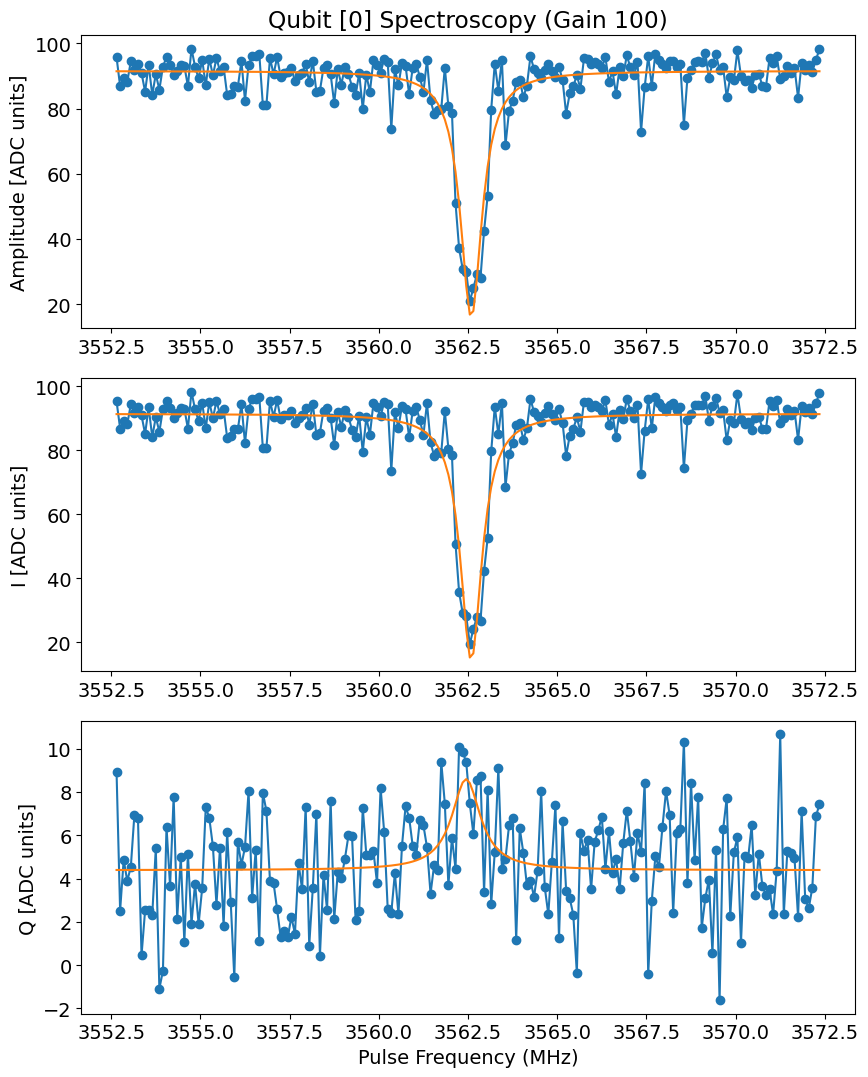

In [5]:
gespec_expt.display()

## Amplitude Rabi

In [ ]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
amprabi_defaults = AttrDict(dict(
    start=0,
    step=60,
    expts=151,
    reps=200,
    rounds=1,
    sigma_test=None,
    qubit=0,
    pulse_type='gauss',
    drag_beta=0.0,
    pulse_ge_init=False,
    pulse_ge_after=False,
    checkZZ=False,
    checkEF=False,
    qubits=[0],
    flat_length=0,
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=50,
    user_defined_freq=[False, 3568.203829046816],
    prepulse=False,
    postpulse=False, 
    if_ef=False,  # If true, will check ef frequency and update it
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values

def amprabi_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)

    # Copied over but what's all this below????
    # Which ones are actually used? 
    # Can we straighten out all the nested boolean logic???
    pulse_ge = station.hardware_cfg.device.qubit.pulses.pi_ge
    if expt_cfg.sigma_test is None:
        expt_cfg.sigma_test = pulse_ge.sigma[0]
    if expt_cfg.step is None:
        expt_cfg.step = int(pulse_ge.gain[0] / (expt_cfg.expts - 1))
    
    expt_cfg.checkEF = False
    expt_cfg.pulse_ge_init = False
    expt_cfg.pulse_ge_after = False
    if expt_cfg.if_ef:
        expt_cfg.checkEF = True
        expt_cfg.pulse_ge_init = True
        expt_cfg.pulse_ge_after = True
    
    return expt_cfg

def amprabi_postproc(station, expt):
    station.hardware_cfg.device.qubit.pulses.pi_ge.gain = [expt.data['pi_gain_avgi']]
    station.hardware_cfg.device.qubit.pulses.hpi_ge.gain = [expt.data['hpi_gain_avgi']]
    print('Updated qubit ge pi and hpi gaussian gain!')

In [ ]:
# Execute
# =================================
amprabi_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.AmplitudeRabiExperiment,
    default_expt_cfg=amprabi_defaults,
    preprocessor=amprabi_preproc,
    postprocessor=amprabi_postproc,
    job_client=client,
)

amprabi_expt = amprabi_runner.execute(
    # use_queue=False, # Uncomment to run locally without job queue
    relax_delay=2500,
    # post_process=True,
)

Job submitted: JOB-20260115-00003 (queue position: 1)
[0.1s] Job JOB-20260115-00003: pending
[2.1s] Job JOB-20260115-00003: running
[82.6s] Job JOB-20260115-00003: completed
Job completed! Data: D:\experiments\260115_job_worker\data\JOB-20260115-00003_AmplitudeRabiExperiment.h5
Updated qubit ge pi and hpi gaussian gain!


Pi gain from avgi data [dac units]: 3279
	Pi/2 gain from avgi data [dac units]: 1601
Pi gain from avgq data [dac units]: 3693
	Pi/2 gain from avgq data [dac units]: 1967


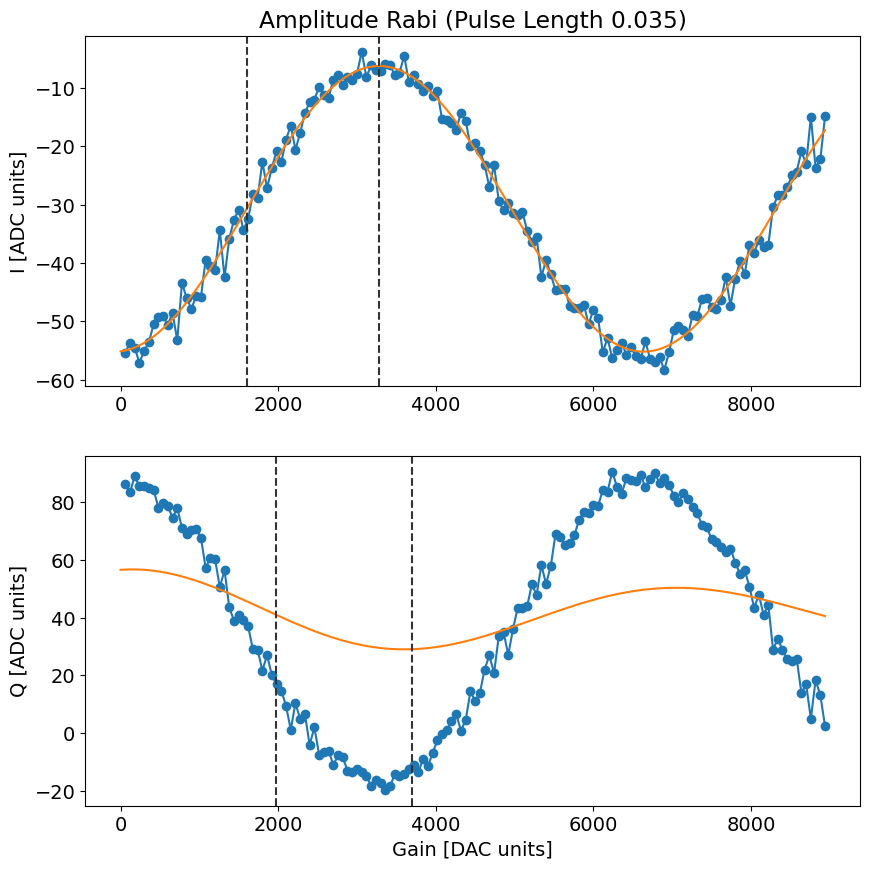

In [8]:
amprabi_expt.display()

# Final snapshot of config ID(s)

In [ ]:
# Configs are snapshotted BEFORE the experiment is run using the config in station. After the last experiment you run, create another config after the experiment and update it to the "main" config, stored in the database (accessible by others).
station.update_all_station_snapshots(update_main=True)

[CONFIG] Created new hardware_config version CFG-HW-20260115-00004
[CONFIG] Reusing existing multiphoton_config version CFG-MP-20260115-00001
[CONFIG] Reusing existing man1_storage_swap version CFG-M1-20260115-00002
[CONFIG] Reusing existing floquet_storage_swap version CFG-FL-20260115-00001
Config snapshots for current station:
  hardware_config: CFG-HW-20260115-00004
  multiphoton_config: CFG-MP-20260115-00001
  man1_storage_swap: CFG-M1-20260115-00002
  floquet_storage_swap: CFG-FL-20260115-00001
[CONFIG] Updated main hardware_config to CFG-HW-20260115-00004
[CONFIG] Updated main multiphoton_config to CFG-MP-20260115-00001
[CONFIG] Updated main man1_storage_swap to CFG-M1-20260115-00002
[CONFIG] Updated main floquet_storage_swap to CFG-FL-20260115-00001
Configs saved and set as main!


{'hardware_config': 'CFG-HW-20260115-00004',
 'multiphoton_config': 'CFG-MP-20260115-00001',
 'man1_storage_swap': 'CFG-M1-20260115-00002',
 'floquet_storage_swap': 'CFG-FL-20260115-00001'}

In [ ]:
# Or call them individually
station.snapshot_hardware_config(update_main=True)
# station.snapshot_multiphoton_config(update_main=True)
# station.snapshot_storage_config(update_main=True)
# station.snapshot_floquet_config(update_main=True)

## Summary

In [ ]:
print("JOB AND CONFIG IDS")

# Qubit Spectroscopy
spec_result = gespec_runner.last_job_result
print(f"\nQubit Spectroscopy:")
print(f"  Job ID:                   {spec_result.job_id}")
print("Configs used:")
print(f"  Hardware YAML:            {spec_result.hardware_config_version_id}")
print(f"  Multiphoton YAML:         {spec_result.multiphoton_config_version_id}")
print(f"  Man1-storage csv:         {spec_result.man1_storage_version_id}")
print(f"  Data File:                {spec_result.data_file_path}")
print(f"  Expt Object Pickle File:  {spec_result.expt_pickle_path}")

# Amplitude Rabi
rabi_result = amprabi_runner.last_job_result
print(f"\nAmplitude Rabi:")
print(f"  Job ID:                   {rabi_result.job_id}")
print(f"  Hardware Config:          {rabi_result.hardware_config_version_id}")
print(f"  Data File:                {rabi_result.data_file_path}")
print(f"  Expt Object Pickle File:  {rabi_result.expt_pickle_path}")

print("\n" + "=" * 60)
print("CALIBRATION RESULTS")
print("=" * 60)
print(f"Qubit frequency:  {station.hardware_cfg.device.qubit.f_ge[0]} MHz")
print(f"Pi-pulse gain:    {station.hardware_cfg.device.qubit.pulses.pi_ge.gain[0]}")

JOB AND CONFIG IDS

Qubit Spectroscopy:
  Job ID:                   JOB-20260115-00007
Configs used:
  Hardware YAML:            CFG-HW-20260115-00004
  Multiphoton YAML:         CFG-MP-20260115-00001
  Man1-storage csv:         CFG-M1-20260115-00002
  Data File:                D:\experiments\260115_job_worker\data\JOB-20260115-00007_PulseProbeSpectroscopyExperiment.h5
  Expt Object Pickle File:  D:\experiments\260115_job_worker\expt_objs\JOB-20260115-00007_expt.pkl


NameError: name 'amprabi_runner' is not defined

## Config Versioning

The job system tracks versioned snapshots of config files. Key operations:

1. **View available versions** - List all snapshots of a config type
2. **Create a new version** - Snapshot a config file (automatically done by worker, or manually)
3. **Set main config** - Point "main" to a specific version ID (this is stored in the database jobs.db)
4. **Pull main config** - Get the path to the current main config

In [7]:
from pathlib import Path
from job_server.database import get_database
from job_server.config_versioning import ConfigVersionManager
from job_server.models import ConfigType

# Initialize database and config manager
db = get_database()

# Adjust this path to your multimode_expts location
CONFIG_DIR = Path("D:/python/multimode_expts/configs")
config_manager = ConfigVersionManager(CONFIG_DIR)

In [8]:
# 1. List all available config versions
print("Available Hardware Config Versions:")
print("-" * 70)

with db.session() as session:
    versions = config_manager.list_versions(ConfigType.HARDWARE_CONFIG, session)
    for v in versions[:10]:  # Show last 10
        print(f"  {v.version_id}  {v.original_filename}  ({v.created_at})")

Available Hardware Config Versions:
----------------------------------------------------------------------
  CFG-HW-20260115-00002  hardware_config_202505.yml  (2026-01-15 21:26:07.476503)
  CFG-HW-20260115-00001  hardware_config_202505.yml  (2026-01-15 21:24:30.792608)
  CFG-HW-20260115-00004  hardware_config_202505.yml  (2026-01-15 14:33:28.362371)
  CFG-HW-20260115-00003  hardware_config_202505.yml  (2026-01-15 13:52:56.471008)


In [33]:
# 2. Create a new config version (snapshot a config file)
# This creates a versioned copy with a unique ID like CFG-HW-20260114-00001

HARDWARE_CONFIG_PATH = CONFIG_DIR / "hardware_config_202505.yml"

with db.session() as session:
    version_id, snapshot_path = config_manager.snapshot_hardware_config(
        source_path=HARDWARE_CONFIG_PATH,
        session=session,
        job_id=None,  # Optional: link to a job
    )
    print(f"Created config version: {version_id}")
    print(f"Snapshot saved to: {snapshot_path}")

[CONFIG] Reusing existing version CFG-HW-20260114-00001 (same checksum)
Created config version: CFG-HW-20260114-00001
Snapshot saved to: D:\python\multimode_expts\configs\versions\hardware_config\CFG-HW-20260114-00001_hardware_config_202505.yml


In [9]:
# 3. Set a specific version as the "main" config
# This is useful when you want to switch back to a previous known-good config

# First, let's see what the current main config is (if any)
with db.session() as session:
    main_config = config_manager.get_main_version(ConfigType.HARDWARE_CONFIG, session)
    if main_config:
        print(f"Current main config: {main_config.version_id}")
    else:
        print("No main config set yet")

# Now set a specific version as main
# Replace with an actual version_id from the list above
with db.session() as session:
    # Get the most recent version to use as an example
    versions = config_manager.list_versions(ConfigType.HARDWARE_CONFIG, session)
    if versions:
        example_version_id = versions[0].version_id  # Most recent
        config_manager.set_main_version(
            config_type=ConfigType.HARDWARE_CONFIG,
            version_id=example_version_id,
            session=session,
            updated_by="Claude",
        )
        print(f"Set main config to: {example_version_id}")

No main config set yet
[CONFIG] Set main hardware_config to CFG-HW-20260115-00002


OperationalError: (sqlite3.OperationalError) database is locked
[SQL: INSERT INTO main_configs (config_type, version_id, updated_at, updated_by) VALUES (?, ?, ?, ?)]
[parameters: ('HARDWARE_CONFIG', 'CFG-HW-20260115-00002', '2026-01-15 15:02:21.777549', 'Claude')]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [36]:
# 4. Get/pull the main config path
# Use this when you need to load the current "canonical" config

with db.session() as session:
    main_path = config_manager.get_main_config_path(ConfigType.HARDWARE_CONFIG, session)
    if main_path:
        print(f"Main config path: {main_path}")
        print(f"File exists: {main_path.exists()}")
    else:
        print("No main config path set")

Main config path: D:\python\multimode_expts\configs\versions\hardware_config\CFG-HW-20260114-00001_hardware_config_202505.yml
File exists: True


In [37]:
# 5. Push: Snapshot a config AND set it as main in one step
# This is the most common operation when you've updated your config and want to publish it

with db.session() as session:
    version_id, snapshot_path = config_manager.push_hardware_config_to_main(
        source_path=HARDWARE_CONFIG_PATH,
        session=session,
        updated_by="Claude",
    )
    print(f"Created and set as main: {version_id}")
    print(f"Snapshot path: {snapshot_path}")

[CONFIG] Reusing existing version CFG-HW-20260114-00001 (same checksum)
[CONFIG] Updated main hardware_config to CFG-HW-20260114-00001
Created and set as main: CFG-HW-20260114-00001
Snapshot path: D:\python\multimode_expts\configs\versions\hardware_config\CFG-HW-20260114-00001_hardware_config_202505.yml


### Using Config Versions with Jobs

When jobs run, the worker automatically snapshots the current configs and records the version IDs with the job. You can see which config versions were used by checking `last_job_result`:

```python
result = runner.last_job_result
print(f"Hardware config used: {result.hardware_config_version_id}")
print(f"Multiphoton config used: {result.multiphoton_config_version_id}")
```

The worker uses the configs from the station's paths at execution time. Config versioning is primarily for:
1. **Reproducibility** - Know exactly which config was used for each job
2. **Rollback** - Switch "main" back to a previous known-good config
3. **Audit trail** - Track config changes over time